# Predicting SalePrice

## Objectives

Create and evaluate model to predict SalePrice of building

## Inputs:
* outputs/datasets/cleaned/test.parquet.gzip
* outputs/datasets/cleaned/train.parquet.gzip
* Conclusions from Feature Engineering jupyter_notebooks/04_Feature_Engineering.ipynb

## Outputs
* Train Set: Features and Target
* Test Set: Features and Target
* Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,0,856,854.0,3.0,No,706,GLQ,150,0.0,548,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,3,961,NaN,NaN,No,216,ALQ,540,NaN,642,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we drop features:

In [5]:
drop_features = ['Unnamed: 0']
df.drop(columns=drop_features, inplace=True)

### Cleaning Dataset

In [6]:
df.loc[:, 'LotFrontage'] = df['LotFrontage'].fillna(70)

# Lists of columns grouped by their fill values and type conversions
fill_zero_and_convert = ['1stFlrSF', '2ndFlrSF', 'GarageArea', 'GarageYrBlt',
                         'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF', 'BedroomAbvGr']
fill_none = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish']

# Fill missing values with zero and convert to integers for numerical columns
df[fill_zero_and_convert] = df[fill_zero_and_convert].fillna(0).astype(int)

# Fill missing values with 'None' for categorical columns
df[fill_none] = df[fill_none].fillna('None')
df['LotFrontage'] = df['LotFrontage'].round().astype(int)

df.loc[df['2ndFlrSF'] == 0, 'BedroomAbvGr'] = df['BedroomAbvGr'].replace(0, 2)
df.loc[df['2ndFlrSF'] > 0, 'BedroomAbvGr'] = df['BedroomAbvGr'].replace(0, 3)

# Swap values where '2ndFlrSF' is greater than '1stFlrSF'
swap_idx = df['2ndFlrSF'] > df['1stFlrSF']
df.loc[swap_idx, ['1stFlrSF', '2ndFlrSF']] = df.loc[swap_idx, ['2ndFlrSF', '1stFlrSF']].values

# Define features and their 'no presence' values
basement_features = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF']
features_and_values = {"BsmtExposure": "None", "BsmtFinType1": "None", "BsmtFinSF1": 0, "BsmtUnfSF": 0,
                       "TotalBsmtSF": 0}

# Check and update inconsistencies for each feature
for feature in basement_features:
    primary_value = features_and_values[feature]
    df['Consistency'] = df.apply(
        lambda row: all(row[f] == v for f, v in features_and_values.items()) if row[feature] == primary_value else True,
        axis=1
    )
    inconsistent_idx = df[~df['Consistency']].index
    if feature in ['BsmtExposure', 'BsmtFinType1']:
        correction = 'No' if feature == 'BsmtExposure' else 'Unf'
        df.loc[inconsistent_idx, feature] = correction

# Dropping new created column Consistency
df = df.drop(columns=['Consistency'])

# Correct zero values and adjust inconsistent records using vectorized operations
df.loc[df['BsmtUnfSF'] == 0, 'BsmtUnfSF'] = df['TotalBsmtSF'] - df['BsmtFinSF1']
df.loc[df['BsmtFinSF1'] == 0, 'BsmtFinSF1'] = df['TotalBsmtSF'] - df['BsmtUnfSF']
df.loc[df['TotalBsmtSF'] == 0, 'TotalBsmtSF'] = df['BsmtUnfSF'] + df['BsmtFinSF1']

# Identify and adjust records with inconsistent basement measurements using a ratio (example: 3)
mask = df['BsmtFinSF1'] + df['BsmtUnfSF'] != df['TotalBsmtSF']
df.loc[mask, 'BsmtUnfSF'] = (df.loc[mask, 'TotalBsmtSF'] / 3).astype(int)
df.loc[mask, 'BsmtFinSF1'] = df.loc[mask, 'TotalBsmtSF'] - df.loc[mask, 'BsmtUnfSF']

# Define a dictionary for checking consistency based on 'GarageFinish'
features_and_values = {"GarageArea": 0, "GarageFinish": 'None', "GarageYrBlt": 0}


def check_consistency(df, primary_feature):
    primary_value = features_and_values[primary_feature]
    return df.apply(
        lambda row: all(row[feature] == value for feature, value in features_and_values.items())
        if row[primary_feature] == primary_value else True, axis=1
    )


# Apply consistency check and correct 'GarageFinish'
consistency_mask = check_consistency(df, 'GarageFinish')
df.loc[~consistency_mask, 'GarageFinish'] = 'Unf'

# Correct garage years that are earlier than the house build year
df.loc[df['GarageYrBlt'] < df['YearBuilt'], 'GarageYrBlt'] = df['YearBuilt']

## Splitting to data and test dataframe

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='SalePrice')
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Machine Learning

### Pre-Transformations

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import category_encoders as ce

# Define custom FeatureCreator class
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


class FeatureCreator(BaseEstimator, TransformerMixin):
    """Custom feature creator for pipeline integration.

    This class extends sklearn's TransformerMixin to allow for custom feature
    creation during preprocessing pipelines. It handles various mathematical
    transformations and feature interactions explicitly detailed within the
    transform method, ensuring all features are appropriately processed and added.

    """

    def fit(self, X, y=None):
        # The fit method is not used for adding features, it's just here for compatibility.
        return self

    def transform(self, X):
        """Apply a series of custom transformations to the dataframe.

        Args:
        X (pd.DataFrame): Input dataframe from which features are derived.

        Returns:
        pd.DataFrame: The dataframe with new features added.

        """
        X = X.copy()  # Work on a copy of the data to prevent changes to the original dataframe
        
        # New features descriptions to be presented in Pipeline i
        self.feature_creation_descriptions_ = {
            'NF_TotalBsmtSF_mul_BsmtExposure': 'TotalBsmtSF * BsmtExposure',
            'NF_TotalBsmtSF_mul_BsmtFinType1': 'TotalBsmtSF * BsmtFinSF1',
            'NF_BsmtFinSF1_mul_BsmtFinType1': 'BsmtFinType1 * BsmtFinSF1',
            'NF_GarageFinish_mul_GarageArea': 'GarageFinish * GarageArea',
            'NF_TotalLivingArea': 'GrLivArea + 1stFlrSF + 2ndFlrSF',
            'NF_TotalLivingArea_mul_OverallQual': 'NF_TotalLivingArea * OverallQual',
            'NF_TotalLivingArea_mul_OverallCond': 'NF_TotalLivingArea * OverallCond',
            'NF_1stFlrSF_mul_OverallQual': '1stFlrSF * OverallQual',
            'NF_2ndFlrSF_mul_OverallQual': '2ndFlrSF * OverallQual',
            'NF_Age_Garage': '2010 - GarageYrBlt',
            'NF_Age_Build': '2010 - YearBuilt',
            'NF_Age_Remod': '2010 - YearRemodAdd',
            'NF_Remod_TEST': '0 if NF_Age_Build == NF_Age_Remod else NF_Age_Remod',
            'NF_Has_2nd_floor': '1 if 2ndFlrSF > 0 else 0',
            'NF_Has_basement': '1 if TotalBsmtSF > 0 else 0',
            'NF_Has_garage': '1 if GarageArea > 0 else 0',
            'NF_Has_Masonry_Veneer': '1 if MasVnrArea > 0 else 0',
            'NF_Has_Enclosed_Porch': '1 if EnclosedPorch > 0 else 0',
            'NF_Has_Open_Porch': '1 if OpenPorchSF > 0 else 0',
            'NF_Has_ANY_Porch': 'NF_Has_Enclosed_Porch | NF_Has_Open_Porch',
            'NF_Has_Wooden_Deck': '1 if WoodDeckSF > 0 else 0'
        }
        # Numeric and Boolean feature interactions and transformations
        X['NF_TotalBsmtSF_mul_BsmtExposure'] = X['TotalBsmtSF'] * X['BsmtExposure']
        X['NF_TotalBsmtSF_mul_BsmtFinType1'] = X['TotalBsmtSF'] * X['BsmtFinSF1']
        X['NF_BsmtFinSF1_mul_BsmtFinType1'] = X['BsmtFinType1'] * X['BsmtFinSF1']
        X['NF_GarageFinish_mul_GarageArea'] = X['GarageFinish'] * X['GarageArea']
        X['NF_TotalLivingArea'] = X['GrLivArea'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['NF_TotalLivingArea_mul_OverallQual'] = X['NF_TotalLivingArea'] * X['OverallQual']
        X['NF_TotalLivingArea_mul_OverallCond'] = X['NF_TotalLivingArea'] * X['OverallCond']
        X['NF_1stFlrSF_mul_OverallQual'] = X['1stFlrSF'] * X['OverallQual']
        X['NF_2ndFlrSF_mul_OverallQual'] = X['2ndFlrSF'] * X['OverallQual']
        X['NF_Age_Garage'] = 2010 - X['GarageYrBlt']
        X['NF_Age_Build'] = 2010 - X['YearBuilt']
        X['NF_Age_Remod'] = 2010 - X['YearRemodAdd']
        X['NF_Remod_TEST'] = X.apply(
            lambda row: 0 if row['NF_Age_Build'] == row['NF_Age_Remod'] else row['NF_Age_Remod'], axis=1)
        X[('NF_Has_2nd_floor')] = X.apply(lambda row: False if row['2ndFlrSF'] == 0 else True, axis=1).astype(int)
        X[('NF_Has_basement')] = X.apply(lambda row: False if row['TotalBsmtSF'] == 0 else True, axis=1).astype(int)
        X[('NF_Has_garage')] = X.apply(lambda row: False if row['GarageArea'] == 0 else True, axis=1).astype(int)
        X[('NF_Has_Masonry_Veneer')] = X.apply(lambda row: False if row['MasVnrArea'] == 0 else True, axis=1).astype(
            int)
        X[('NF_Has_Enclosed_Porch')] = X.apply(lambda row: False if row['EnclosedPorch'] == 0 else True,
                                               axis=1).astype(int)
        X[('NF_Has_Open_Porch')] = X.apply(lambda row: False if row['OpenPorchSF'] == 0 else True, axis=1).astype(int)
        X['NF_Has_ANY_Porch'] = X['NF_Has_Enclosed_Porch'] | X['NF_Has_Open_Porch'].astype(int)
        X[('NF_Has_Wooden_Deck')] = X.apply(lambda row: False if row['WoodDeckSF'] == 0 else True, axis=1).astype(int)

        self.output_features_ = X.columns.tolist()
        return X

    def get_feature_names_out(self, input_features=None):
        """Return feature names for the transformed features."""
        return self.output_features_
    def __repr__(self):
        feature_descriptions = "\n".join([f"{name}: {desc}" for name, desc in self.feature_creation_descriptions_.items()])
        return f"FeatureCreator(created_features:\n{feature_descriptions})"



# Mapping and encoder setup
encoding_dict = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'KitchenQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
}

ordinal_encoder = ce.OrdinalEncoder(mapping=[
    {'col': k, 'mapping': v} for k, v in encoding_dict.items()
])

# Pipeline setup
pre_feature_transformations = Pipeline(steps=[
    ('ordinal_encoder', ordinal_encoder),  # Custom categorical encoding
    ('feature_creator', FeatureCreator())  # Custom feature creation
])

### Features - Columns transformations

In [42]:
from sklearn.pipeline import Pipeline
from feature_engine.transformation import YeoJohnsonTransformer, BoxCoxTransformer, PowerTransformer

# Define the columns for each transformation type
yeo_johnson_features = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtUnfSF', 'EnclosedPorch',
                        'GarageArea', 'GarageFinish', 'GrLivArea', 'KitchenQual', 'LotArea', 'MasVnrArea',
                        'OpenPorchSF', 'OverallCond', 'TotalBsmtSF', 'WoodDeckSF', 'NF_TotalBsmtSF_mul_BsmtExposure',
                        'NF_BsmtFinSF1_mul_BsmtFinType1', 'NF_GarageFinish_mul_GarageArea', 'NF_TotalLivingArea',
                        'NF_Age_Garage', 'NF_Age_Remod', 'NF_Remod_TEST', 'NF_TotalLivingArea_mul_OverallQual',
                        'NF_TotalLivingArea_mul_OverallCond', 'NF_1stFlrSF_mul_OverallQual',
                        'NF_2ndFlrSF_mul_OverallQual']
power_features = ['GarageYrBlt', 'LotFrontage', 'YearRemodAdd', 'NF_TotalBsmtSF_mul_BsmtFinType1', 'NF_Age_Build']
box_cox_features = []

# Create transformers for each group of features using feature_engine transformers
yeo_johnson_transformer = YeoJohnsonTransformer(variables=yeo_johnson_features)
power_transformer = PowerTransformer(variables=power_features, exp=0.5)
box_cox_transformer = BoxCoxTransformer(variables=box_cox_features)

# Combine all transformers into a single pipeline
feature_transformer = Pipeline([
    ('yeo_johnson', yeo_johnson_transformer),
    ('power', power_transformer),
])


### Features-Columns Post Transformations

In [43]:
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# Define the columns for Winsorization
winsorize_features = ['GarageArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 'NF_TotalBsmtSF_mul_BsmtExposure',
                      'NF_TotalLivingArea_mul_OverallCond']

# Initialize the Winsorizer transformer
# We will apply Winsorizer to features from table in jupyter_notebooks/08_Feature_Engineering_hypothesis_3.ipynb
# The ones which gad high or above outliers
winsorize_transformer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=winsorize_features)


# Create the post-feature transformations pipeline
post_feature_transformer = Pipeline([
    ('winsorize', winsorize_transformer),
    ('standard_scaler', StandardScaler())
])


### Target Transformations

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin



class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Add a small constant to avoid log(0)
        return np.log1p(np.clip(X, 0, None))

    def inverse_transform(self, X):
        # Use expm1 for numerical stability, clip to avoid overflow
        return np.expm1(np.clip(X, None, 700))  # 700 is chosen to avoid overflow in expm1



# Create a pipeline for transforming the target variable
target_transformation_pipeline = Pipeline([
    ('log_transform', LogTransformer()),  # Log transformation
])


class PassthroughTransformer(BaseEstimator, TransformerMixin):
    """A transformer that passes through the data without changing it."""

    def fit(self, X, y=None):
        # No fitting necessary for passthrough
        return self

    def transform(self, X):
        # Return the data as is
        return X

    def inverse_transform(self, X):
        # Return the data as is
        return X


# Create a pipeline for passthrough transformation
passthrough_transformation_pipeline = Pipeline([
    ('passthrough', PassthroughTransformer())  # Passthrough transformer
])



### Main Pipeline 

In [45]:
from sklearn.base import is_regressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SelectFromModel

def supports_feature_selection(model):
    """
    Check if the model supports feature selection.
    A model supports feature selection if it has 'coef_' or 'feature_importances_' attribute.
    
    Parameters:
    - model: The model to check.
    
    Returns:
    - bool: True if the model supports feature selection, False otherwise.
    """
    return hasattr(model, 'coef_') or hasattr(model, 'feature_importances_')

def create_pipeline(model, target_transformer):
    """
    Create a pipeline with preprocessing, feature transformation, selection, and modeling.
    
    Parameters:
    - model: The regressor model to be used in the pipeline.
    - target_transformer: The transformer for the target variable.
    
    Returns:
    - main_pipeline: A scikit-learn Pipeline object.
    """
    steps = [
        ('pre_transformations', pre_feature_transformations),  # Preprocessing steps
        ('transformations', feature_transformer),  # Feature transformations
        ('post_transformations', post_feature_transformer),  # Post-transformations
    ]

    # Conditionally add feature selection step
    if supports_feature_selection(model):
        steps.append(('feat_selection', SelectFromModel(model)))  # Feature selection

    # Add the model with target transformation step
    steps.append(('model', TransformedTargetRegressor(regressor=model, transformer=target_transformer)))

    # Define the complete pipeline
    main_pipeline = Pipeline(steps)

    return main_pipeline


## ML Pipeline for Modeling and Hyperparameters Optimization

This is custom Class Hyperparameter Optimization

In [46]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd


class grid_cv_search_hp:
    """
    Class to perform hyperparameter optimization across multiple machine learning models.
    
    Attributes:
        models (dict): Dictionary of models to evaluate.
        params (dict): Dictionary of hyperparameters for the models.
        grid_searches (dict): Dictionary to store the results of GridSearchCV.
    """

    def __init__(self, models, params, target_transformer):
        """
        Initializes the GridCvSearchHP with models and parameters.
        
        Args:
            models (dict): A dictionary of model names and instances.
            params (dict): A dictionary of model names and their hyperparameters.
            target_transformer: Transformer to apply to the target variable.
        """
        self.models = models
        self.params = params
        self.grid_searches = {}
        self.target_transformer = target_transformer

    def fit(self, X, y, cv, n_jobs, verbose=10, scoring='r2', refit=False):
        """
        Perform hyperparameter optimization using GridSearchCV for each model.
        
        Args:
            X (array-like): Training data features.
            y (array-like): Training data target values.
            cv (int): Number of cross-validation folds.
            n_jobs (int): Number of jobs to run in parallel.
            verbose (int): Controls the verbosity of the output.
            scoring (str): Scoring metric for model evaluation.
            refit (bool): Whether to refit the best model on the whole dataset after searching.
        
        Returns:
            None
        """
        for key in self.models:
            print(f"\nOptimizing hyperparameters for {key}...\n")
            model = create_pipeline(self.models[key], self.target_transformer)
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Summarize the grid search results.
        
        Args:
            sort_by (str): The column to sort the results by.
        
        Returns:
            DataFrame: A pandas DataFrame containing the summary of grid search results.
            dict: The grid search results.
        """

        def row(key, scores, params):
            """Creates a row for the summary dataframe."""
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Grid Search CV

For this time being we will use default hyperparameters, just to select best algorithms

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, QuantileRegressor, \
    RANSACRegressor, Lars, OrthogonalMatchingPursuit, HuberRegressor, TheilSenRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression

# Initializing regression models with default parameters

# Linear Models
linear_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=100000),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
    'QuantileRegressor': QuantileRegressor(),
    'RANSACRegressor': RANSACRegressor(),
    'PLSRegression': PLSRegression(),
    'HuberRegressor': HuberRegressor(max_iter=1000),
    'TheilSenRegressor': TheilSenRegressor()
}

# Tree-Based Models
tree_based_models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor()
}

# Gradient Boosting Frameworks
gradient_boosting_models = {
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'CatBoostRegressor': CatBoostRegressor()
}

# Support Vector Machines
svm_models = {
    'SVR': SVR(),
    'NuSVR': NuSVR(),
    'LinearSVR': LinearSVR(max_iter=100000)
}

# Nearest Neighbors
nearest_neighbors_models = {
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RadiusNeighborsRegressor': RadiusNeighborsRegressor(radius=20.0) # Uncomment if needed
}

# Bayesian Methods
bayesian_models = {
    'GaussianProcessRegressor': GaussianProcessRegressor()
}

# Combining all models into a single dictionary for quick search
models_quick_search = {
    **linear_models,
    **tree_based_models,
    **gradient_boosting_models,
    **svm_models,
    **nearest_neighbors_models,
    **bayesian_models
}

# Define an empty hyperparameter dictionary as all models will use default parameters initially
params_quick_search = {model_name: {} for model_name in models_quick_search}


### Running Grid Search CV

In [ ]:
initial_search = grid_cv_search_hp(models=models_quick_search, params=params_quick_search,
                                   target_transformer=target_transformation_pipeline)
initial_search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring='r2', refit=False)

In [ ]:
import numpy as np

grid_search_summary, grid_search_pipelines = initial_search.score_summary()
grid_search_summary

### Summary of Regressors by Category

1. **Linear Models**
   * BayesianRidge, 0.860079
   * PLSRegression, 0.853426
   * Ridge, 0.851585
   * HuberRegressor, 0.845978
   * LinearRegression, 0.842141
   * RANSACRegressor, 0.795119
   * TheilSenRegressor, 0.285762
   * Lasso, -0.036293
   * ElasticNet, -0.036293
   * QuantileRegressor, -0.055394

2. **Tree-Based Models**
   * HistGradientBoostingRegressor, 0.858713
   * RandomForestRegressor, 0.853213
   * ExtraTreesRegressor, 0.843201
   * GradientBoostingRegressor, 0.833988
   * AdaBoostRegressor, 0.793819
   * DecisionTreeRegressor, 0.698089

3. **Gradient Boosting Frameworks**
   * CatBoostRegressor, 0.856161
   * LGBMRegressor, 0.851544
   * XGBRegressor, 0.828049

4. **Support Vector Machines**
   * LinearSVR, 0.846725
   * NuSVR, 0.842756
   * SVR, 0.827245

5. **Nearest Neighbors**
   * KNeighborsRegressor, 0.800393

6. **Bayesian Methods**
   * GaussianProcessRegressor, -6.150232

We can see that the top-performing models are from the BayesianRidge, HistGradientBoostingRegressor, and CatBoostRegressor categories.

Let's test the top 2 regressors from each category. Even though they show high scores, it does not mean they are the best for a given model.
* We will skip GaussianProcessRegressor as it is way too low. This model does not work for the given dataset and transformations.

## Regressors Exploration

### BayesianRidge

In [56]:
from sklearn.linear_model import BayesianRidge

# Define the models
models_tune_search_bayesianridge = {
    "BayesianRidge": BayesianRidge(),
}

# Define the parameter grid with appropriate settings
params_tune_search_bayesianridge = {
    "BayesianRidge": {
        'model__regressor__max_iter': [300, 600, 1000],  # Number of iterations for convergence. Increasing iterations can improve accuracy but increase computation time.
        'model__regressor__tol': [1e-3, 1e-4, 1e-5],  # Tolerance for the stopping criteria. Lower values lead to more precise convergence but longer training times.
        'model__regressor__alpha_1': [1e-6, 1e-5, 1e-4],  # Hyperparameter for the alpha parameter (prior distribution). Controls regularization strength; lower values reduce overfitting.
        'model__regressor__alpha_2': [1e-6, 1e-5, 1e-4],  # Hyperparameter for the alpha parameter (prior distribution). Controls regularization strength; lower values reduce overfitting.
        'model__regressor__lambda_1': [1e-6, 1e-5, 1e-4],  # Hyperparameter for the lambda parameter (prior distribution). Controls regularization strength for weight precision; lower values reduce overfitting.
        'model__regressor__lambda_2': [1e-6, 1e-5, 1e-4],  # Hyperparameter for the lambda parameter (prior distribution). Controls regularization strength for weight precision; lower values reduce overfitting.
    }
}


In [57]:
search_tuned_br = grid_cv_search_hp(models=models_tune_search_bayesianridge, params=params_tune_search_bayesianridge,
                                     target_transformer=target_transformation_pipeline)
search_tuned_br.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5, refit=True)


Optimizing hyperparameters for BayesianRidge...

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 2/5; 1/9] START model__regressor__lambda_1=1e-06, model__regressor__lambda_2=1e-06
[CV 2/5; 1/9] END model__regressor__lambda_1=1e-06, model__regressor__lambda_2=1e-06;, score=0.684 total time=   0.8s
[CV 5/5; 1/9] START model__regressor__lambda_1=1e-06, model__regressor__lambda_2=1e-06
[CV 5/5; 1/9] END model__regressor__lambda_1=1e-06, model__regressor__lambda_2=1e-06;, score=0.916 total time=   0.9s
[CV 5/5; 2/9] START model__regressor__lambda_1=1e-06, model__regressor__lambda_2=1e-05
[CV 5/5; 2/9] END model__regressor__lambda_1=1e-06, model__regressor__lambda_2=1e-05;, score=0.916 total time=   0.8s
[CV 4/5; 3/9] START model__regressor__lambda_1=1e-06, model__regressor__lambda_2=0.0001
[CV 4/5; 3/9] END model__regressor__lambda_1=1e-06, model__regressor__lambda_2=0.0001;, score=0.895 total time=   0.7s
[CV 3/5; 4/9] START model__regressor__lambda_1=1e-05, model__reg

In [59]:
models_tune_summary_br, models_tune_pipelines_br = search_tuned_br.score_summary(sort_by='mean_score')
models_tune_summary_br

,estimator,min_score,mean_score,max_score,std_score,model__regressor__alpha_1,model__regressor__alpha_2,model__regressor__lambda_1,model__regressor__lambda_2,model__regressor__max_iter,model__regressor__tol
224,BayesianRidge,0.684282,0.860081,0.915975,0.088294,0.000001,0.0001,0.0001,0.000001,1000,0.00001
218,BayesianRidge,0.684282,0.860081,0.915975,0.088294,0.000001,0.0001,0.0001,0.000001,300,0.00001
221,BayesianRidge,0.684282,0.860081,0.915975,0.088294,0.000001,0.0001,0.0001,0.000001,600,0.00001
464,BayesianRidge,0.684282,0.860081,0.915975,0.088294,0.00001,0.0001,0.0001,0.000001,600,0.00001
461,BayesianRidge,0.684282,0.860081,0.915975,0.088294,0.00001,0.0001,0.0001,0.000001,300,0.00001
...,...,...,...,...,...,...,...,...,...,...,...
261,BayesianRidge,0.684185,0.860058,0.915988,0.088332,0.00001,0.000001,0.000001,0.0001,300,0.001
267,BayesianRidge,0.684185,0.860058,0.915988,0.088332,0.00001,0.000001,0.000001,0.0001,1000,0.001
510,BayesianRidge,0.684185,0.860058,0.915988,0.088332,0.0001,0.000001,0.000001,0.0001,1000,0.001
507,BayesianRidge,0.684185,0.860058,0.915988,0.088332,0.0001,0.000001,0.000001,0.0001,600,0.001


In [60]:
import joblib

joblib.dump(models_tune_pipelines_br, 'models/hypothesis_3/models_tune_pipelines_br.pkl')
models_tune_summary_br.to_csv('models/hypothesis_3/models_tune_summary_br.csv', index=False)

In [61]:
# Selecting best Model

best_model_br = models_tune_summary_br.iloc[0]['estimator']
best_model_br

'BayesianRidge'

In [62]:
# Best parameters

best_parameters_br = models_tune_pipelines_br[best_model_br].best_params_
best_parameters_br

{'model__regressor__alpha_1': 1e-06,
 'model__regressor__alpha_2': 0.0001,
 'model__regressor__lambda_1': 0.0001,
 'model__regressor__lambda_2': 1e-06,
 'model__regressor__max_iter': 300,
 'model__regressor__tol': 1e-05}

{'model__regressor__alpha_1': 1e-06,
 'model__regressor__alpha_2': 0.0001,
 'model__regressor__lambda_1': 0.0001,
 'model__regressor__lambda_2': 1e-06,
 'model__regressor__max_iter': 300,
 'model__regressor__tol': 1e-05}

In [63]:
# Best Pipeline

best_pipeline_br = models_tune_pipelines_br[best_model_br].best_estimator_
best_pipeline_br

Pipeline(steps=[('pre_transformations',
                 Pipeline(steps=[('ordinal_encoder',
                                  OrdinalEncoder(cols=['BsmtExposure',
                                                       'BsmtFinType1',
                                                       'GarageFinish',
                                                       'KitchenQual'],
                                                 mapping=[{'col': 'BsmtExposure',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
No      1
Mn      2
Av      3
Gd      4
dtype: int64},
                                                          {'col': 'BsmtFinType1',
                                                           'data_type': dtype('O'),
                                                           'mapping': None    0
Unf     1
LwQ     2
Rec     3
BLQ     4
ALQ     5
GLQ     6
dtype: int64},
                                                          {'co...
                                             tail='both',
                                             variables=['GarageArea', 'LotArea',
                                                        'LotFrontage',
                                                        'TotalBsmtSF',
                                                        'NF_TotalBsmtSF_mul_BsmtExposure',
                                                        'NF_TotalLivingArea_mul_OverallCond'])),
                                 ('standard_scaler', StandardScaler())])),
                ('model',
                 TransformedTargetRegressor(regressor=BayesianRidge(alpha_2=0.0001,
                                                                    lambda_1=0.0001,
                                                                    tol=1e-05),
                                            transformer=Pipeline(steps=[('log_transform',
                                                                         LogTransformer())])))])

## Accessing Feature Importance

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

sns.set_style('whitegrid')

def plot_feature_importance_absolute(selected_pipeline):
    """
    Plot the absolute feature importance from a given pipeline.

    Args:
        selected_pipeline (Pipeline): The complete pipeline including feature selection and model.

    Raises:
        AttributeError: If the sub-pipeline does not support the transform operation.
        ValueError: If there is a mismatch in feature support mask length and transformed features.
    """
    def extract_model(pipeline):
        """
        Extract the final model from the pipeline.
        """
        for step_name, step in pipeline.steps:
            if isinstance(step, TransformedTargetRegressor):
                return step.regressor_
            elif hasattr(step, 'feature_importances_') or hasattr(step, 'coef_'):
                return step
        return None

    try:
        # Extract the sub-pipeline up to the model step
        feature_names = None
        for name, step in selected_pipeline.named_steps.items():
            if name == 'model':
                break
            if hasattr(step, 'get_feature_names_out'):
                if feature_names is None:
                    feature_names = step.get_feature_names_out()
                else:
                    feature_names = step.get_feature_names_out(feature_names)
            else:
                # Simulate the transformation to get feature names
                if feature_names is None:
                    feature_names = step.transform(pd.DataFrame(columns=[f'feature_{i}' for i in range(step.transform(pd.DataFrame()).shape[1])])).columns.tolist()
                else:
                    feature_names = step.transform(pd.DataFrame(columns=feature_names)).columns.tolist()

        if feature_names is None:
            raise ValueError("Could not retrieve transformed feature names.")

        # Extract the final model from the pipeline
        model = extract_model(selected_pipeline)

        if model is None:
            raise ValueError("The model does not have feature importances or coefficients.")

        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_type = 'importance'
        elif hasattr(model, 'coef_'):
            importances = model.coef_.flatten()
            importance_type = 'coefficient'
        else:
            raise ValueError("The model does not have feature importances or coefficients.")

        # Create a DataFrame for feature importances or coefficients
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            importance_type: importances
        }).sort_values(by=importance_type, ascending=False)

        # Plotting the feature importances or coefficients
        plt.figure(figsize=(12, 8))
        sns.barplot(x=importance_type, y='Feature', data=feature_importances_df)
        plt.xlabel(importance_type.capitalize())
        plt.ylabel('Feature')
        plt.title(f'Feature {importance_type.capitalize()}s')
        plt.show()

    except KeyError as e:
        print(f"KeyError: {e}")
    except AttributeError as e:
        print(f"AttributeError: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


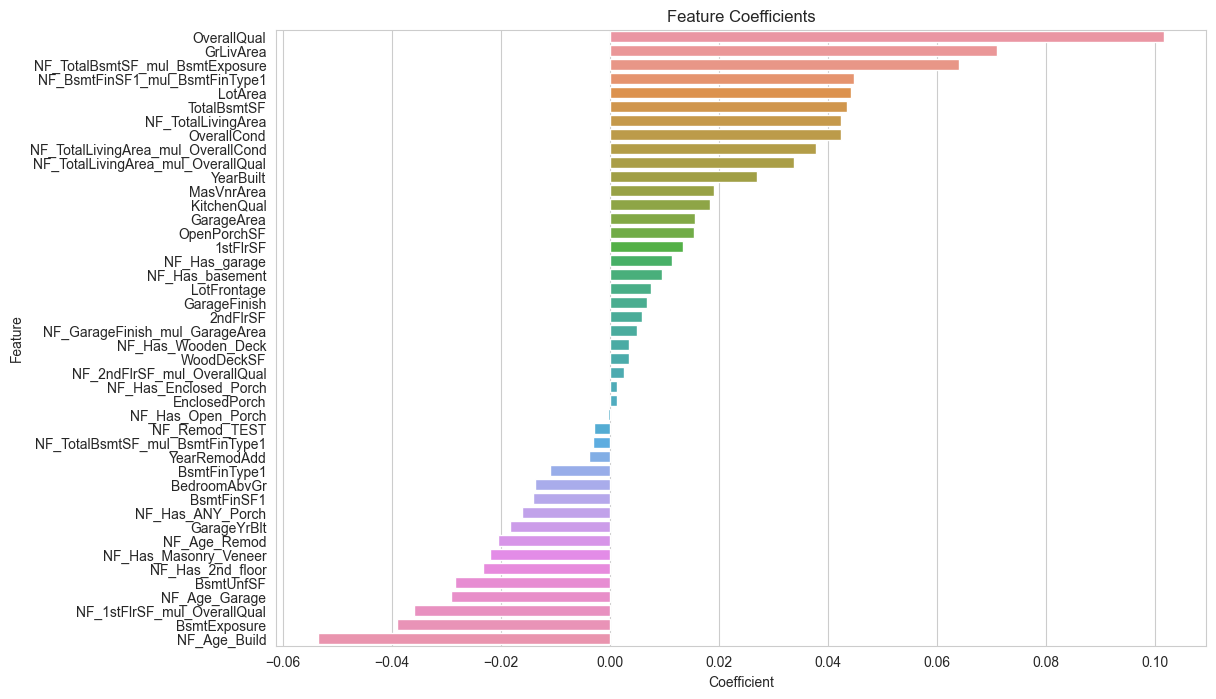

In [65]:
plot_feature_importance_absolute(best_pipeline_br)

Let's get all Features sorted by their importance

In [66]:
def get_sorted_feature_importances(selected_pipeline):
    """
    Retrieve and return the feature importances or coefficients from a given pipeline, sorted by absolute value.

    Args:
        selected_pipeline (Pipeline): The complete pipeline including feature selection and model.

    Returns:
        pd.DataFrame: DataFrame containing features and their absolute importances or coefficients, sorted by absolute value.
    """
    def extract_model(pipeline):
        """
        Extract the final model from the pipeline.
        """
        for step_name, step in pipeline.steps:
            if isinstance(step, TransformedTargetRegressor):
                return step.regressor_
            elif hasattr(step, 'feature_importances_') or hasattr(step, 'coef_'):
                return step
        return None

    try:
        # Extract the sub-pipeline up to the model step
        feature_names = None
        for name, step in selected_pipeline.named_steps.items():
            if name == 'model':
                break
            if hasattr(step, 'get_feature_names_out'):
                if feature_names is None:
                    feature_names = step.get_feature_names_out()
                else:
                    feature_names = step.get_feature_names_out(feature_names)
            else:
                # Simulate the transformation to get feature names
                if feature_names is None:
                    feature_names = step.transform(pd.DataFrame(columns=[f'feature_{i}' for i in range(step.transform(pd.DataFrame()).shape[1])])).columns.tolist()
                else:
                    feature_names = step.transform(pd.DataFrame(columns=feature_names)).columns.tolist()

        if feature_names is None:
            raise ValueError("Could not retrieve transformed feature names.")

        # Extract the final model from the pipeline
        model = extract_model(selected_pipeline)

        if model is None:
            raise ValueError("The model does not have feature importances or coefficients.")

        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_type = 'importance'
        elif hasattr(model, 'coef_'):
            importances = model.coef_.flatten()
            importance_type = 'coefficient'
        else:
            raise ValueError("The model does not have feature importances or coefficients.")

        # Create a DataFrame for feature importances or coefficients
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            importance_type: importances,
            f'abs_{importance_type}': np.abs(importances)
        }).sort_values(by=f'abs_{importance_type}', ascending=False)

        return feature_importances_df[['Feature', importance_type, f'abs_{importance_type}']]

    except KeyError as e:
        print(f"KeyError: {e}")
    except AttributeError as e:
        print(f"AttributeError: {e}")
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [67]:
get_sorted_feature_importances(best_pipeline_br)

,Feature,coefficient,abs_coefficient
18,OverallQual,0.101547,0.101547
11,GrLivArea,0.070964,0.070964
23,NF_TotalBsmtSF_mul_BsmtExposure,0.064017,0.064017
33,NF_Age_Build,-0.053575,0.053575
25,NF_BsmtFinSF1_mul_BsmtFinType1,0.044777,0.044777
13,LotArea,0.044134,0.044134
19,TotalBsmtSF,0.043466,0.043466
27,NF_TotalLivingArea,0.042298,0.042298
17,OverallCond,0.042250,0.042250
3,BsmtExposure,-0.039204,0.039204


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Evaluates the performance of a regression model on both the training and test sets.
    
    Args:
        X_train (array-like): Training data features.
        y_train (array-like): Training data target values.
        X_test (array-like): Test data features.
        y_test (array-like): Test data target values.
        pipeline (Pipeline): The regression model pipeline to evaluate.
    """
    r2_train, mae_train, mse_train, rmse_train, msle_train = regression_evaluation(X_train, y_train, pipeline)
    r2_test, mae_test, mse_test, rmse_test, msle_test = regression_evaluation(X_test, y_test, pipeline)
    return (r2_train, mae_train, mse_train, rmse_train, msle_train), (r2_test, mae_test, mse_test, rmse_test, msle_test)

def regression_evaluation(X, y, pipeline):
    """
    Evaluates a regression model on a given dataset and prints key metrics.
    
    Args:
        X (array-like): Data features.
        y (array-like): Data target values.
        pipeline (Pipeline): The regression model pipeline to evaluate.
    """
    prediction = pipeline.predict(X)
    r2 = r2_score(y, prediction)
    mae = mean_absolute_error(y, prediction)
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(y, prediction)


    return r2, mae, mse, rmse, msle

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Plots actual vs predicted values for both training and test sets.
    
    Args:
        X_train (array-like): Training data features.
        y_train (array-like): Training data target values.
        X_test (array-like): Test data features.
        y_test (array-like): Test data target values.
        pipeline (Pipeline): The regression model pipeline to evaluate.
        alpha_scatter (float): Transparency of the scatter plot points.
    """
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    # Train set evaluation
    r2_train, mae_train, mse_train, rmse_train, msle_train = regression_evaluation(X_train, y_train, pipeline)
    # Test set evaluation
    r2_test, mae_test, mse_test, rmse_test, msle_test = regression_evaluation(X_test, y_test, pipeline)

    # Train plot: Actual vs Predicted
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0, 0], color='blue')
    axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predictions")
    axes[0, 0].set_title("Train Set: Actual vs Predicted")
    train_metrics_text = (f'R2: {round(r2_train, 3)}\n'
                          f'MAE: {round(mae_train, 3)}\n'
                          f'MSE: {round(mse_train, 3)}\n'
                          f'RMSE: {round(rmse_train, 3)}\n'
                          f'MSLE: {round(msle_train, 3)}')
    axes[0, 0].text(0.05, 0.95, train_metrics_text, transform=axes[0, 0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

    # Test plot: Actual vs Predicted
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[0, 1], color='green')
    axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, 1].set_xlabel("Actual Values")
    axes[0, 1].set_ylabel("Predictions")
    axes[0, 1].set_title("Test Set: Actual vs Predicted")
    test_metrics_text = (f'R2: {round(r2_test, 3)}\n'
                         f'MAE: {round(mae_test, 3)}\n'
                         f'MSE: {round(mse_test, 3)}\n'
                         f'RMSE: {round(rmse_test, 3)}\n'
                         f'MSLE: {round(msle_test, 3)}')
    axes[0, 1].text(0.05, 0.95, test_metrics_text, transform=axes[0, 1].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

    # Residuals plot: Train
    residuals_train = y_train - pred_train
    sns.scatterplot(x=pred_train, y=residuals_train, alpha=alpha_scatter, ax=axes[1, 0], color='blue')
    axes[1, 0].axhline(0, color='r', linestyle='--')
    axes[1, 0].set_xlabel("Predictions")
    axes[1, 0].set_ylabel("Residuals")
    axes[1, 0].set_title("Train Set: Residuals")

    # Residuals plot: Test
    residuals_test = y_test - pred_test
    sns.scatterplot(x=pred_test, y=residuals_test, alpha=alpha_scatter, ax=axes[1, 1], color='green')
    axes[1, 1].axhline(0, color='r', linestyle='--')
    axes[1, 1].set_xlabel("Predictions")
    axes[1, 1].set_ylabel("Residuals")
    axes[1, 1].set_title("Test Set: Residuals")

    # Error distribution plot: Train
    sns.histplot(residuals_train, kde=True, ax=axes[1, 2], color='blue')
    axes[1, 2].set_xlabel("Residuals")
    axes[1, 2].set_ylabel("Frequency")
    axes[1, 2].set_title("Train Set: Error Distribution")

    # Error distribution plot: Test
    sns.histplot(residuals_test, kde=True, ax=axes[0, 2], color='green')
    axes[0, 2].set_xlabel("Residuals")
    axes[0, 2].set_ylabel("Frequency")
    axes[0, 2].set_title("Test Set: Error Distribution")

    plt.tight_layout()
    plt.show()


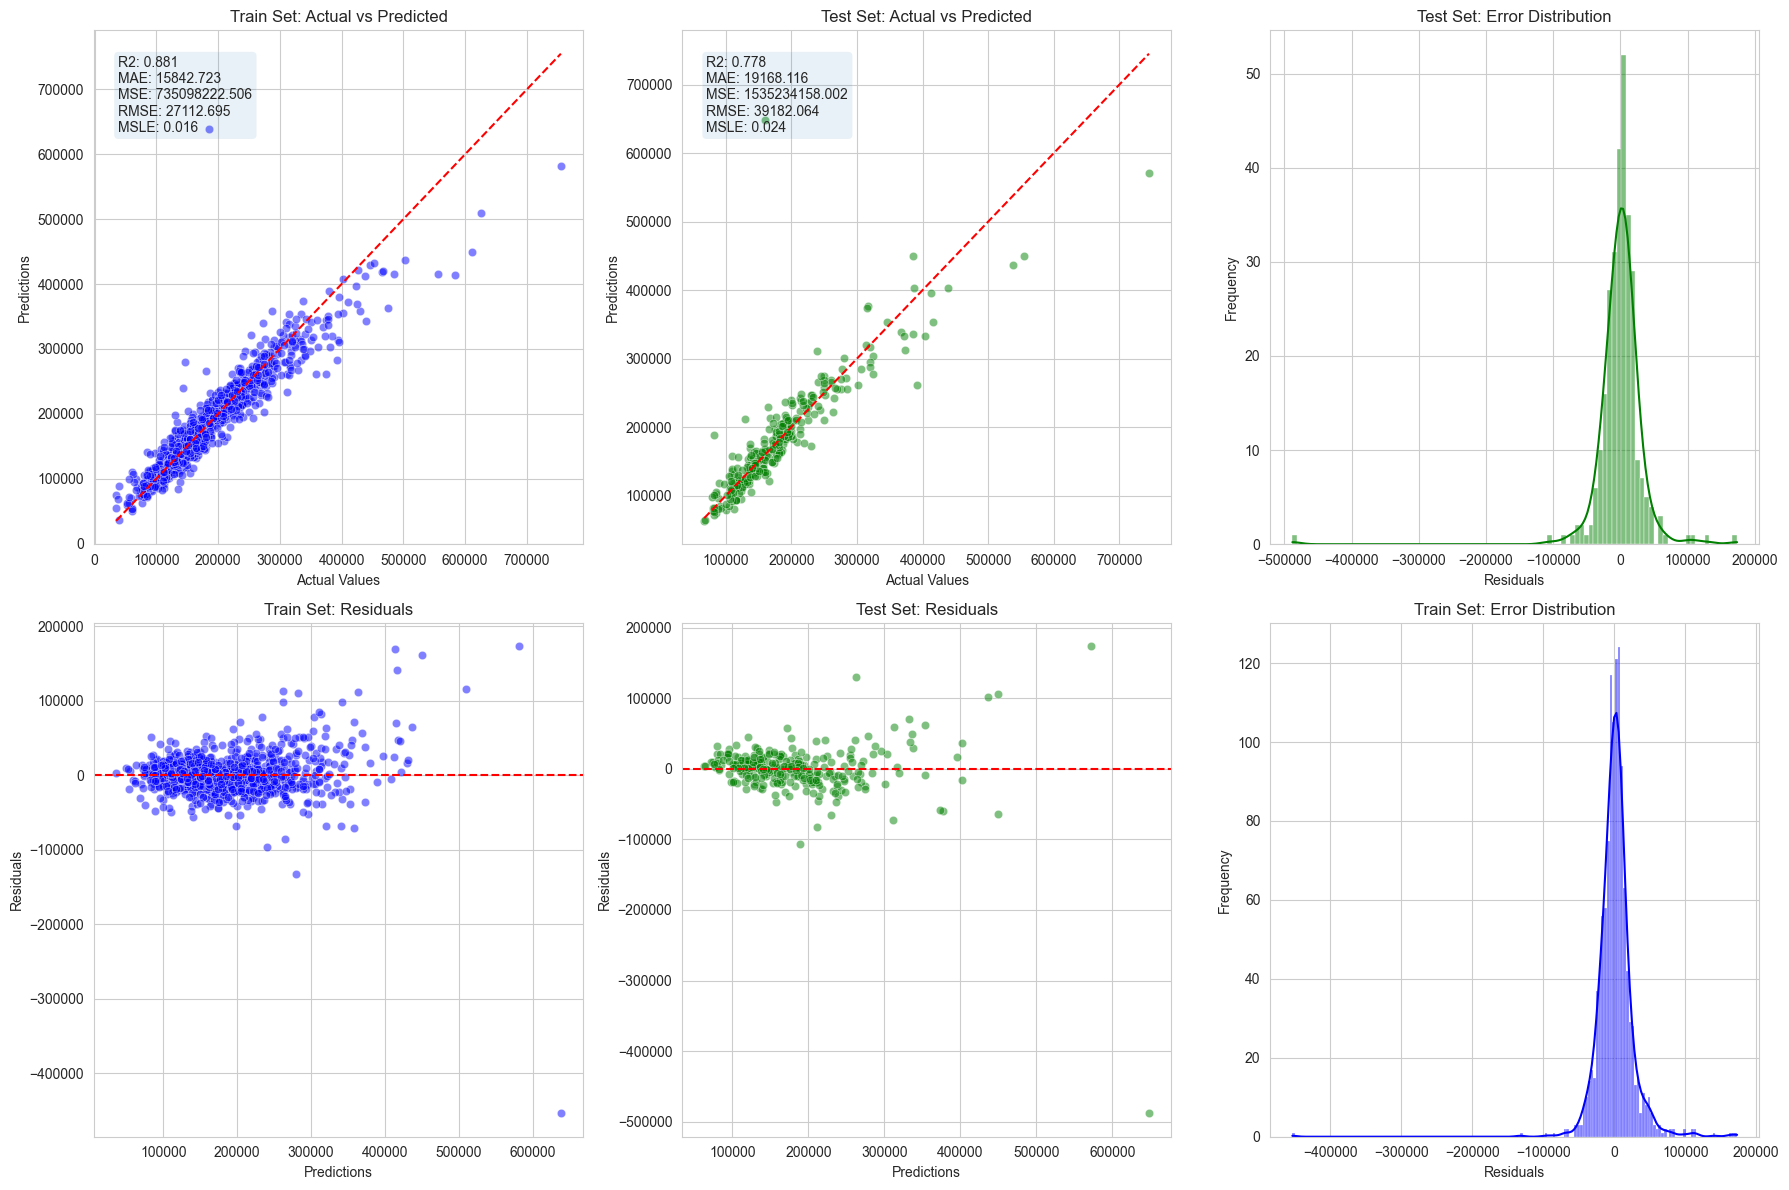

In [69]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline_br)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline_br)

OK, we have some quote promising results:
* Train R<sup>2</sup> = 0.861
* Test R<sup>2</sup> = 0.778

### PLSRegression

In [70]:
from sklearn.cross_decomposition import PLSRegression

# Define the models
models_tune_search_pls = {
    "PLSRegression": PLSRegression(),
}

# Define the parameter grid with appropriate settings
params_tune_search_pls = {
    "PLSRegression": {
        'model__regressor__n_components': [2, 5, 10, 15, 20],  # Number of components to keep.
        'model__regressor__max_iter': [300, 600, 1000, 2000],  # Maximum number of iterations for the algorithm to converge.
        'model__regressor__tol': [1e-6, 1e-7, 1e-8, 1e-9],  # Tolerance for the stopping criteria.
        'model__regressor__algorithm': ['nipals', 'svd'],  # Algorithm used in the decomposition. 'nipals' is more memory efficient, while 'svd' is faster for large datasets.
    }
}
